In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import re 
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("D:\\Downloadss\\kaggle data\\quora similar ques. task data\\train.csv")

In [3]:
new_df = df.sample(30000,random_state=23)

In [4]:
def preprocess(q):
    
    q=str(q).lower().strip()
    
    #replace certain special characters with their string equivalent
    q = q.replace('%','percent')
    q = q.replace('$','dollar')
#     q = q.replace('','repee')
#     q = q.replace('','euro')
    q = q.replace('@','at')
    q = q.replace('&','and')
    
    #The pattern '[math]' appears arouind 900 times in the whole dataset:
    q = q.replace('[math]','')
    
    #Replacing some numbers with string equivalents (not perfect,can be done better to account for more cases)
    q = q.replace(',000,000,000','b') 
    q = q.replace(',000,000','m')
    q = q.replace(',000','k')
    q = re.sub(r'([0-9]+)000000000',r'\1b',q)
    q = re.sub(r'([0-9]+)000000',r'\1b',q)
    q = re.sub(r'([0-9]+)000',r'\1k',q)
    
    #Decontranting words
    #https://stackoverflow.com/a/19794953
    contractions = {
        "ain't":"am not",
        "aren't":"are not",
        "can't":"can not",
        "can't've":"can not have",
        "cause":"because",
        "could've":"could have",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "didn't":"did not"
    }                                 #        #incomplete you can find it from the given link

    q_decontracted =[]
    for word in q.split():
        if word in contractions:
            word = contractions[word]
            
        q_decontracted.append(word)
        
    q=' '.join(q_decontracted)
    q = q.replace("'ve","have")
    q = q.replace("n't","not")
    q = q.replace("re","are")
    q = q.replace("il","will")
    
    
    # Removing html tags 
    q = BeautifulSoup(q)
    q =q.get_text()
    
    #Removing punctuations 
#     pattern = re.compile('\w')
#     q=re.sub(pattern,' ',q).strip()
    
    return q

In [5]:
preprocess("I ain't 've already! wasn't <b>done</b>?")

'i am not have alaready! wasnot done?'

In [6]:
new_df['question1']=new_df['question1'].apply(preprocess)

In [7]:
new_df['question2']=new_df['question2'].apply(preprocess)

In [8]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
237921,237921,9732,79801,is sex necessary in a arelationship?,why is sex important in a good arelationship?,1
181001,181001,277377,277378,what aare the most inspiring start up stories?,what aare the most inspirational stories ever?,0
294691,294691,150129,93109,what is your best way to do digital marketing?,what aare the best unique ways to do digital m...,1
104145,104145,171986,171987,what is the best way to grow a facebook fan page?,how do i get moare followers on my facebook page?,1
357893,357893,487310,487311,suppose host a sends two tcp segments back to ...,suppose host a sends two tcp segments back to ...,1


In [9]:
new_df['q1_len'] = new_df['question1'].str.len()
new_df['q2_len'] = new_df['question2'].str.len()

In [10]:
new_df['q1_num_words']=new_df['question1'].apply(lambda x : len(x.split(" ")))
new_df['q2_num_words']=new_df['question2'].apply(lambda x : len(x.split(" ")))

In [11]:
def common(row):
    x1 = set(map(lambda word : word.lower().strip() , row['question1'].split(" ")))
    x2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return  len(x1 & x2)

In [12]:
new_df['word_common'] = new_df.apply(common,axis= 1)

In [13]:
def total(row):
    x1 = set(map(lambda word : word.lower().strip() , row['question1'].split(" ")))
    x2 = set(map(lambda word : word.lower().strip(), row['question2'].split(" ")))
    return  (len(x1) + len(x2))

In [14]:
new_df['word_total'] = new_df.apply(total,axis=1)

In [15]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)

### Now we will apply advance features  

In [16]:
# TOKEn advance features 
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001
    
    STOP_WORDS = stopwords.words('english')
    
    token_features = [0.0]*8
    
    #CONverting the sentence into tokens:-
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    
    if len(q1_tokens) == 0 or  len(q2_tokens) == 0:
        return token_features
    
    # get non_stopwords in question:-
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # get the stopwords in questions:-
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    #get the common non-stopwords in question:-
    common_words_count = len(q1_words.intersection(q2_words))
    
    #get the common stopwords from question pairs:=
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # get the common tokens from question pairs:-
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0]= common_words_count / (min(len(q1_words) , len(q2_words)) + SAFE_DIV)
    token_features[1]= common_words_count / (max(len(q1_words) ,  len(q2_words)) + SAFE_DIV)
    token_features[2]= common_stop_count / (min(len(q1_stops) ,  len(q2_stops)) + SAFE_DIV)
    token_features[3]= common_stop_count / (max(len(q1_stops) ,  len(q2_stops)) + SAFE_DIV)
    token_features[4]= common_token_count / (min(len(q1_tokens) ,  len(q2_tokens)) + SAFE_DIV)
    token_features[5]= common_token_count / (max(len(q1_tokens) ,  len(q2_tokens)) + SAFE_DIV)
    
    #Last wotd of both question in same onr not:-
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    #first word of both question is same or not:-
    token_features[7] = int(q1_tokens[0]  == q2_tokens[0])
    
    return token_features

In [17]:
token_features = new_df.apply(fetch_token_features,axis =1)
# new_df['cwc_min']

In [18]:
new_df['cwc_min'] = list(map(lambda x: x[0] ,token_features))
new_df['cwc_max'] = list(map(lambda x: x[0] ,token_features))
new_df['csc_min'] = list(map(lambda x: x[0] ,token_features))
new_df['csc_max'] = list(map(lambda x: x[0] ,token_features))
new_df['ctc_min'] = list(map(lambda x: x[0] ,token_features))
new_df['ctc_max'] = list(map(lambda x: x[0] ,token_features))
new_df['last_word_eql'] = list(map(lambda x: x[0] ,token_features))
new_df['first_word_eql'] = list(map(lambda x: x[0] ,token_features))

In [19]:
# pip install distance

In [20]:
# # LENGTH Based Features:
# import distance
# def fetch_length_features(row):
    
#     q1 = row['question1']
#     q2 = row['question2']
    
#     length_features = [0.0]*3
    
#     # converting the sentence into Tokens:
#     q1_tokens = q1.split()
#     q2_tokens = q2.split()
    
#     if len(q1_tokens) == 0 or len(q2_tokens) ==0:
#         return length_features
    
#     # Absolute length features
#     length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
#     #Average Tokens length of botrh Question
#     length_features[1] = (len(q1_tokens) + len(q1_tokens))/2
    
#     strs = list(distance.lcsubstrings(q1,q2))
#     length_features[2] = len(strs[0])  /  (min(len(q1),len(q2)) + 1)
    
#     return length_features

In [21]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # converting the sentence into Tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average Tokens length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens)) / 2
    
    # Calculate longest common substring ratio
    strs = list(distance.lcsubstrings(q1, q2))
    if strs:  # Check if strs is not empty
        length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features

length_features = new_df.apply(fetch_length_features, axis=1)


In [22]:
length_features = new_df.apply(fetch_length_features,axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x:x[1] , length_features))
new_df['longest_substr_ratio'] = list(map(lambda x : x[2] , length_features))

In [23]:
length_features.shape 

(30000,)

In [24]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eql,first_word_eql,as_len_diff,mean_len,longest_substr_ratio
237921,237921,9732,79801,is sex necessary in a arelationship?,why is sex important in a good arelationship?,1,36,45,6,8,...,0.666644,0.666644,0.666644,0.666644,0.666644,0.666644,0.666644,2,7.0,0.405405
181001,181001,277377,277378,what aare the most inspiring start up stories?,what aare the most inspirational stories ever?,0,46,46,8,7,...,0.249994,0.249994,0.249994,0.249994,0.249994,0.249994,0.249994,1,7.5,0.531915
294691,294691,150129,93109,what is your best way to do digital marketing?,what aare the best unique ways to do digital m...,1,46,55,9,10,...,0.749981,0.749981,0.749981,0.749981,0.749981,0.749981,0.749981,1,9.5,0.531915
104145,104145,171986,171987,what is the best way to grow a facebook fan page?,how do i get moare followers on my facebook page?,1,49,49,11,10,...,0.399992,0.399992,0.399992,0.399992,0.399992,0.399992,0.399992,1,10.5,0.200000
357893,357893,487310,487311,suppose host a sends two tcp segments back to ...,suppose host a sends two tcp segments back to ...,1,162,162,30,30,...,0.937494,0.937494,0.937494,0.937494,0.937494,0.937494,0.937494,0,30.0,0.766871


In [25]:
# Now we add fuzzy features 

In [ ]:
# !pip install fuzzywuzzy


In [27]:
from fuzzywuzzy import fuzz

In [31]:
def fetch_fuzzy_features(row):
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    #fuzz_ration
    fuzzy_features[0] = fuzz.QRatio(q1,q2)
    
    #fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1,q2)
    
    #token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1,q2)
    
    #token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1,q2)
    
    return fuzzy_features

In [33]:
fuzzy_features = new_df.apply(fetch_fuzzy_features,axis= 1)

# Creating new features columns for fuzzy features
new_df['fuzz_ratio']= list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1],fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2],fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3],fuzzy_features))

In [34]:
print(new_df.shape)

new_df.head()

(30000, 28)


,id,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,...,ctc_max,last_word_eql,first_word_eql,as_len_diff,mean_len,longest_substr_ratio,fuzz_ration,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
237921,237921,9732,79801,is sex necessary in a arelationship?,why is sex important in a good arelationship?,1,36,45,6,8,...,0.666644,0.666644,0.666644,2,7.0,0.405405,68,64,63,83
181001,181001,277377,277378,what aare the most inspiring start up stories?,what aare the most inspirational stories ever?,0,46,46,8,7,...,0.249994,0.249994,0.249994,1,7.5,0.531915,80,80,78,80
294691,294691,150129,93109,what is your best way to do digital marketing?,what aare the best unique ways to do digital m...,1,46,55,9,10,...,0.749981,0.749981,0.749981,1,9.5,0.531915,79,76,75,85
104145,104145,171986,171987,what is the best way to grow a facebook fan page?,how do i get moare followers on my facebook page?,1,49,49,11,10,...,0.399992,0.399992,0.399992,1,10.5,0.200000,40,45,46,58
357893,357893,487310,487311,suppose host a sends two tcp segments back to ...,suppose host a sends two tcp segments back to ...,1,162,162,30,30,...,0.937494,0.937494,0.937494,0,30.0,0.766871,100,99,100,100


In [40]:
# fuzzy wuzzy libraby ke kuch examples: -

In [41]:
# `fuzzywuzzy` pustakalaya ko import karein
from fuzzywuzzy import process

# Doosre shabdon ki list tay karein
choices = ["apple", "banana", "orange", "grape", "pineapple"]

# Dusra shabd jise hum dhundh rahe hain
query = "aple"

# `process.extractOne()` ka upayog karke sabse achchhe samanjasya wala shabd prapt karein
best_match = process.extractOne(query, choices)

# Prapt samanjasya ko print karein
print("Best Match:", best_match)


Best Match: ('apple', 89)


In [47]:
from fuzzywuzzy import fuzz

# Do strings tay karein
string1 = "Python programming language"
string2 = "Pythn is a easy programmer lnguage"

# Samanjasya star ka anuman lagayein
samanjasya_star = fuzz.ratio(string1, string2)
fuzz_qratio = fuzz.QRatio(string1,string2)
token_sort_ratios = fuzz.token_sort_ratio(string1,string2)
# Samanjasya star ko print karein

print("Samanjasya Star:", samanjasya_star)
print("QRatio is :",fuzz_qratio)
print("token_sort_ratio is :",token_sort_ratios)


Samanjasya Star: 72
QRatio is : 72
token_sort_ratio is : 72


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

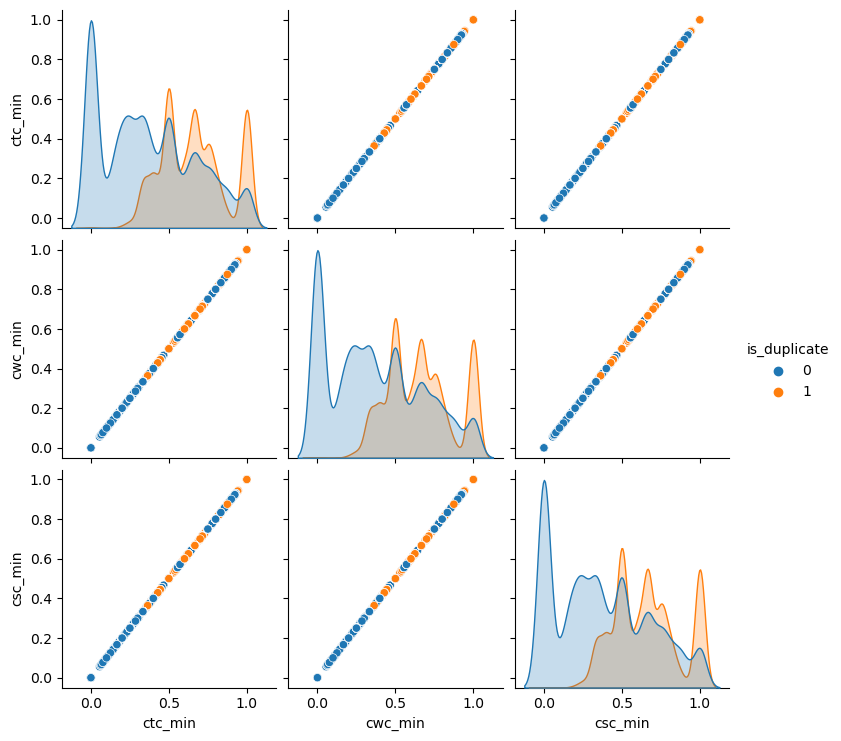

In [51]:
sns.pairplot(new_df[['ctc_min','cwc_min','csc_min','is_duplicate']],hue='is_duplicate')
plt.show()

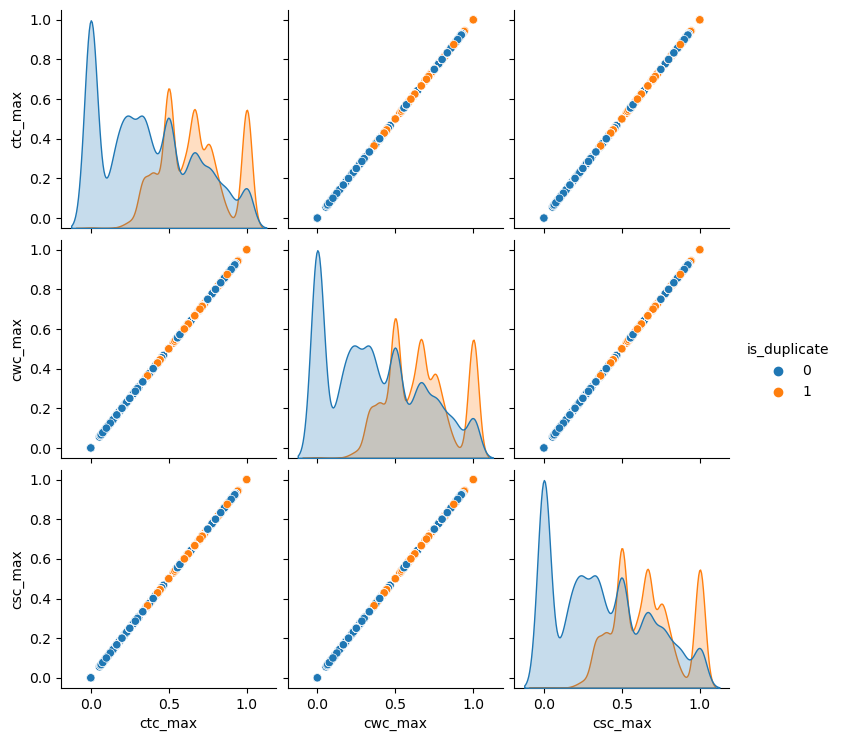

In [52]:
sns.pairplot(new_df[['ctc_max','cwc_max','csc_max','is_duplicate']],hue='is_duplicate')
plt.show()

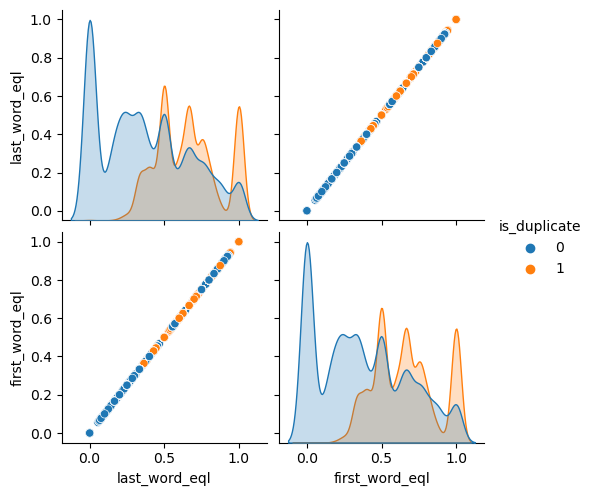

In [54]:
sns.pairplot(new_df[['last_word_eql','first_word_eql','is_duplicate']],hue= 'is_duplicate')

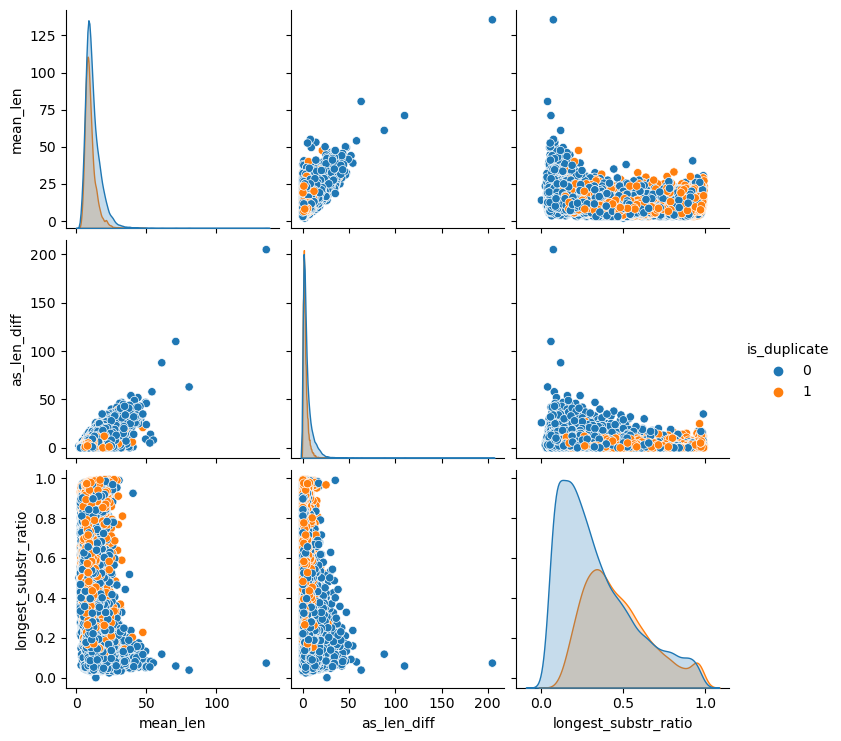

In [57]:
sns.pairplot(new_df[['mean_len','as_len_diff','longest_substr_ratio','is_duplicate']],hue='is_duplicate')

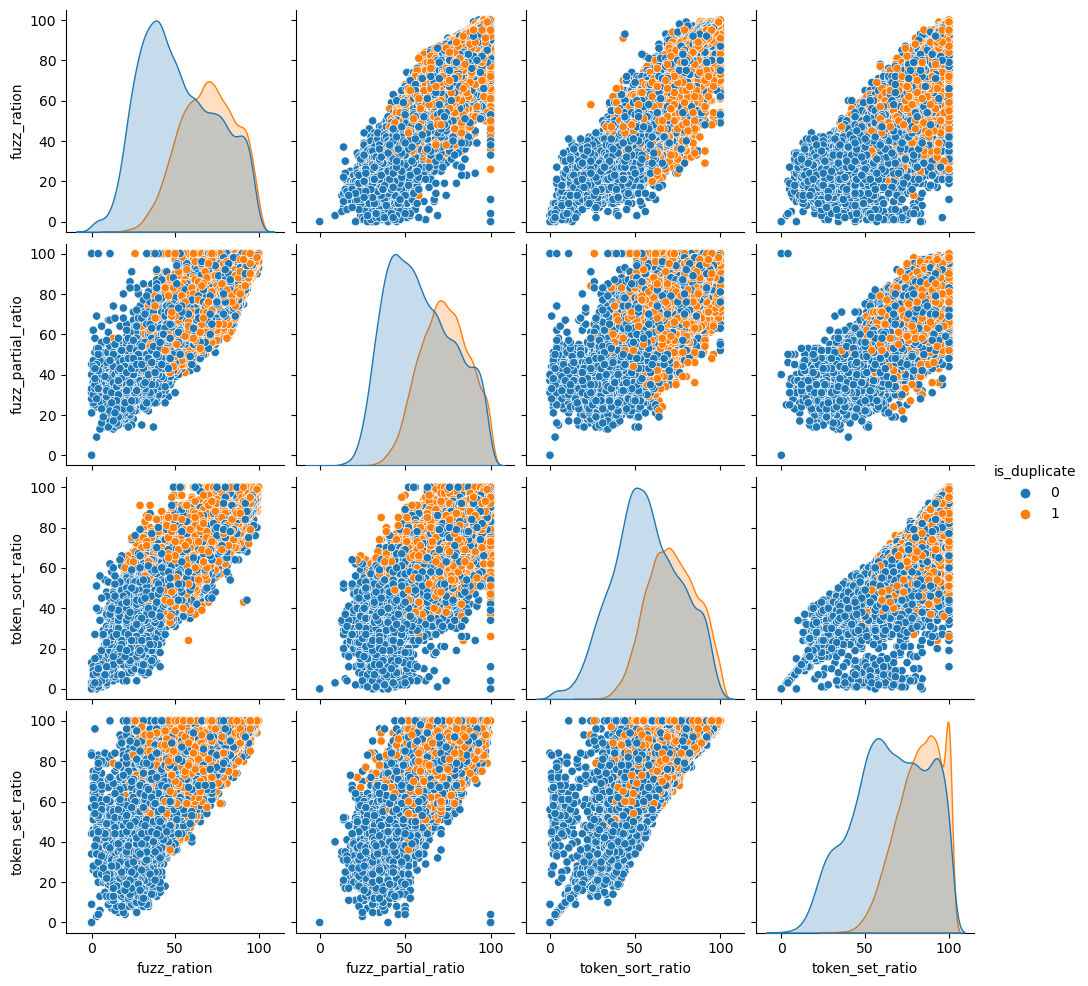

In [59]:
sns.pairplot(new_df[['fuzz_ration','fuzz_partial_ratio','token_sort_ratio','token_set_ratio','is_duplicate']],hue='is_duplicate')